First we need to import the open_hsi and open_hsi_mask classes created beforehand. 
 Then we open the HSI image and its mask.

In [47]:
from my_HSI import open_hsi_mask , open_hsi
PaviaU_classes = ['Asphalt', 'Meadows', 'Gravel', 'Trees', 'Painted metal sheets', 'Bare Soil', 'Bitumen', 'Self-Blocking Bricks', 'Shadows', 'Other']
hsi_image = open_hsi('PaviaU.mat').open_image()
hsi_mask = open_hsi_mask('PaviaU.mat','PaviaU_gt.mat').open_ground_truth()

This code is creating a Pandas DataFrame from an HSI (hyperspectral imaging) image and its corresponding mask. The HSI image has three dimensions: height, width, and the number of layers (bands) of spectral data. The code first extracts the dimensions of the HSI image and saves them in the height, width, and layers variables.

Next, it reshapes the HSI image into a two-dimensional array where each row represents a single pixel in the image and each column represents the intensity of that pixel for each band of the HSI image. This array is then used to create a Pandas DataFrame where each column represents a band of the HSI image. The names of the columns are generated using a list comprehension, resulting in columns named band_0, band_1, and so on.

The code then reshapes the HSI mask into a one-dimensional array and assigns it as the value of the class column in the DataFrame. This class column indicates the class (or label) of each pixel in the HSI image. Finally, the code extracts the values of the class column into the y variable, which will be used as the labels for the HSI image, and the remaining columns of the DataFrame, which represent the features of the HSI image, into the X variable.






In [48]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
height, width, layers = hsi_image.shape
# reshape the image to a 1D array of pixels and 103 features
df = pd.DataFrame(hsi_image.reshape(-1,layers)) 
feature_columns = [f'band_{i}' for i in range(layers)]
df.columns = [feature_columns]
# reshape the mask to a 1D array of pixels
df['class'] = hsi_mask.reshape(-1)
# get the features and the labels
y = df['class'].values
X = df.drop('class', axis = 1)

# standardize the features 
#scaler = StandardScaler()
#scaler.fit(X)
#X = scaler.transform(X)
# split the data into train and test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

This code uses TensorFlow to train a simple neural network for image classification on the HSI image and mask data. The data is first split into features (x) and labels (y). The build_model function defines the architecture of the neural network, which consists of three dense layers with 64, 64, and n units, respectively. The first two layers use the ReLU activation function, while the last layer uses the softmax activation function.

Next, the model is compiled with the RMSprop optimizer and the categorical crossentropy loss function. The model is then trained on the features and labels for five epochs using a batch size of 32. The history object returned by the fit method is used to plot the training and validation loss and accuracy curves. Finally, the trained model is used to predict the class of each pixel in the HSI image and the resulting mask is plotted.

Epoch 1/5
5185/5185 [==============================] - 27s 5ms/step - loss: 4.2605 - accuracy: 0.8356 - val_loss: 1.4730 - val_accuracy: 0.6085
Epoch 2/5
5185/5185 [==============================] - 26s 5ms/step - loss: 0.8818 - accuracy: 0.8401 - val_loss: 1.4940 - val_accuracy: 0.6085
Epoch 3/5
5185/5185 [==============================] - 30s 6ms/step - loss: 0.8075 - accuracy: 0.8401 - val_loss: 1.4696 - val_accuracy: 0.6085
Epoch 4/5
5185/5185 [==============================] - 26s 5ms/step - loss: 0.8225 - accuracy: 0.8401 - val_loss: 1.4779 - val_accuracy: 0.6085
Epoch 5/5
6482/6482 [==============================] - 20s 3ms/step


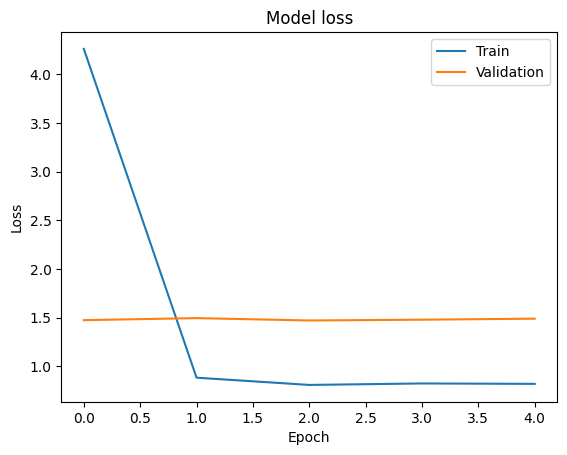

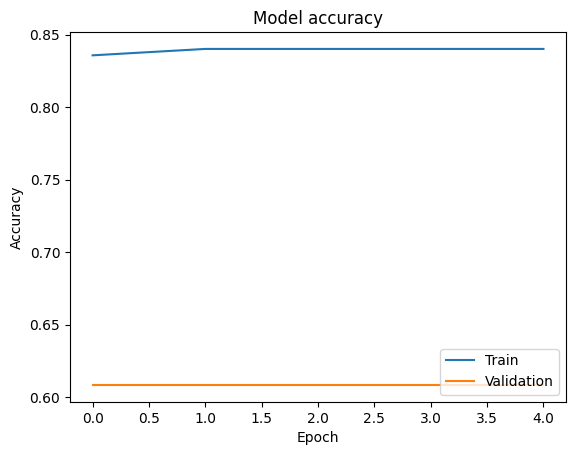

In [91]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
data = df

# Split the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
n = y.unique().max()+1
# Define the model
def build_model(x,n):
  inputs = tf.keras.Input(shape=(x.shape[1]))
  x = layers.Dense(64, activation='relu')(inputs)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(n, activation='softmax')(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the model
model = build_model(x,n)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer='rmsprop', loss= loss, metrics=['accuracy'])

# Train the model
history = model.fit(x, y, batch_size=32, epochs=5, validation_split=0.2)
mask = model.predict(x).argmax(axis=1)


# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

(array([0], dtype=int64), array([207400], dtype=int64))


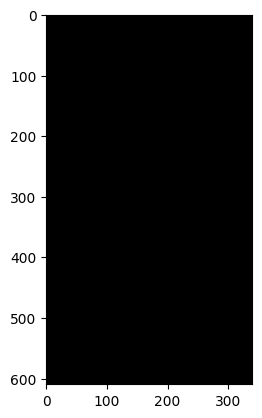

In [93]:
plt.imshow(mask.reshape(height, width), cmap='gray')
print(np.unique(mask, return_counts=True))

array([[<AxesSubplot: title={'center': "('class',)"}>]], dtype=object)

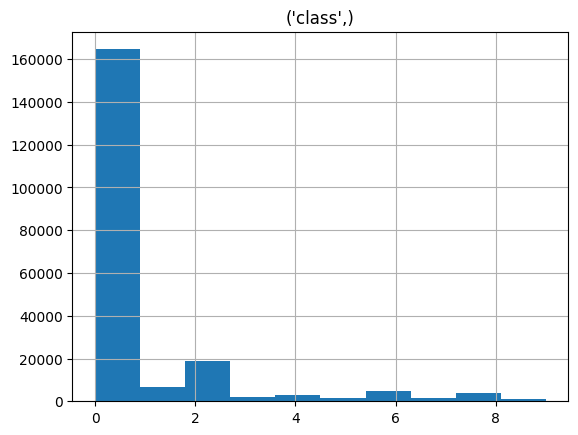

In [134]:
df.hist(column = ['class'])

The model seems to be incorrect, the predicted label for every single feature given is 0, this is due t trhe fact that we have an umbalanced dataset, the number of pixels for each class is not the same, so we need to balance the dataset.

We can get rid of the pixels with the label = 0 to see if the model preformes better

In [220]:
data = df.copy()
data = data.loc[data['class'].values !=0]
data['class'] = data['class'].replace(9,0)
# Split the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
n = y.unique().max() - y.unique().min() +1

Epoch 1/100
1070/1070 [==============================] - 9s 6ms/step - loss: 34.9815 - accuracy: 0.3119 - val_loss: 1.2365 - val_accuracy: 0.9203
Epoch 2/100
1070/1070 [==============================] - 6s 5ms/step - loss: 2.0155 - accuracy: 0.3291 - val_loss: 1.2306 - val_accuracy: 0.9203
Epoch 3/100
1070/1070 [==============================] - 6s 5ms/step - loss: 1.9919 - accuracy: 0.3346 - val_loss: 1.2242 - val_accuracy: 0.9203
Epoch 4/100
1070/1070 [==============================] - 5s 5ms/step - loss: 1.9139 - accuracy: 0.3346 - val_loss: 1.1908 - val_accuracy: 0.9203
Epoch 5/100
1070/1070 [==============================] - 5s 5ms/step - loss: 1.9720 - accuracy: 0.3366 - val_loss: 1.2121 - val_accuracy: 0.9203
Epoch 6/100
1070/1070 [==============================] - 5s 5ms/step - loss: 1.9695 - accuracy: 0.3360 - val_loss: 1.2135 - val_accuracy: 0.9203
Epoch 7/100
1070/1070 [==============================] - 5s 5ms/step - loss: 1.9062 - accuracy: 0.3366 - val_loss: 1.1948 - val_a

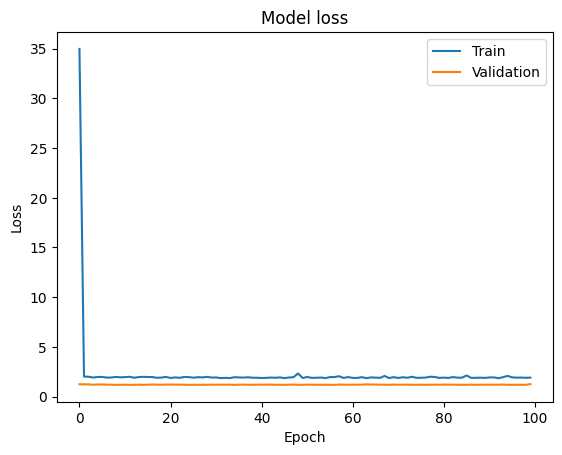

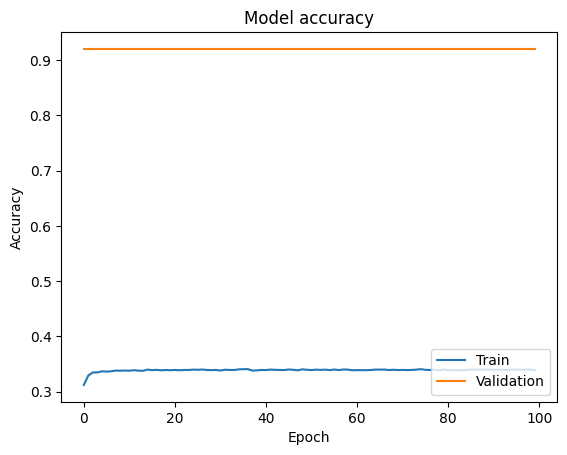

In [224]:

# Define the model
def build_model(x,n):
  inputs = tf.keras.Input(shape=(x.shape[1]))
  x = layers.Dense(64, activation='relu')(inputs)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(n, activation='softmax')(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the model
model = build_model(x,n)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer='rmsprop', loss= loss, metrics=['accuracy'])

# Train the model
history = model.fit(x, y, batch_size=32, epochs=100, validation_split=0.2)
mask = model.predict(x).argmax(axis=1)


# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [225]:
data = df.copy()
# Split the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]
y_proba = model.predict(x)
mask = []
for pred in y_proba:
    mask.append(np.argmax(pred))




6482/6482 [==============================] - 28s 4ms/step


In [232]:
mask = np.array(mask).reshape(height, width)

array([0, 1, 2, 4], dtype=int64)

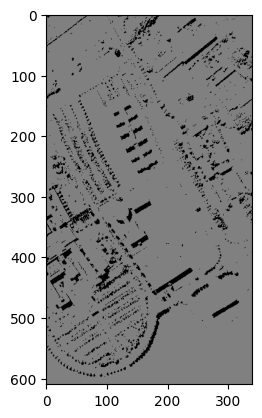

In [235]:
plt.imshow(mask, cmap='gray')
np.unique(mask)

it gives better results but still predicts only the classes 0=9, 1, 2 and 4 

lets try an oversampling of the data

In [236]:
data = df.copy()
# Split the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(x, y)

array([[<AxesSubplot: title={'center': "('class',)"}>]], dtype=object)

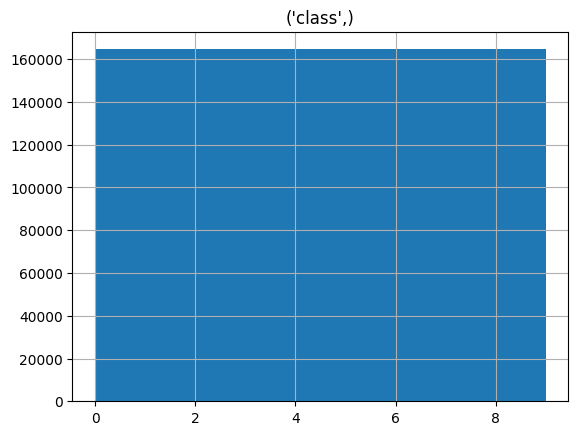

In [237]:
data = pd.DataFrame(X_resampled)
data['class'] = y_resampled
data.hist(column = ['class'])

Epoch 1/5
41156/41156 [==============================] - 369s 9ms/step - loss: 2.4636 - accuracy: 0.1255 - val_loss: 9.6062 - val_accuracy: 0.0000e+00
Epoch 2/5
41156/41156 [==============================] - 231s 6ms/step - loss: 2.1044 - accuracy: 0.1248 - val_loss: 8.9801 - val_accuracy: 0.0000e+00
Epoch 3/5
41156/41156 [==============================] - 219s 5ms/step - loss: 2.1089 - accuracy: 0.1253 - val_loss: 8.5572 - val_accuracy: 0.0000e+00
Epoch 4/5
41156/41156 [==============================] - 223s 5ms/step - loss: 2.1051 - accuracy: 0.1250 - val_loss: 8.7314 - val_accuracy: 0.0000e+00
Epoch 5/5
41156/41156 [==============================] - 232s 6ms/step - loss: 2.1120 - accuracy: 0.1251 - val_loss: 10.5889 - val_accuracy: 0.0000e+00


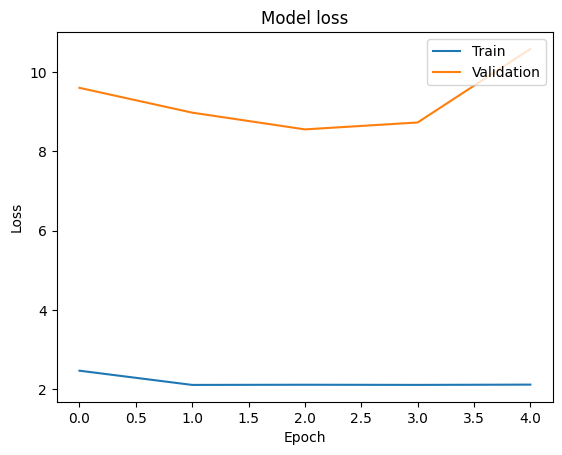

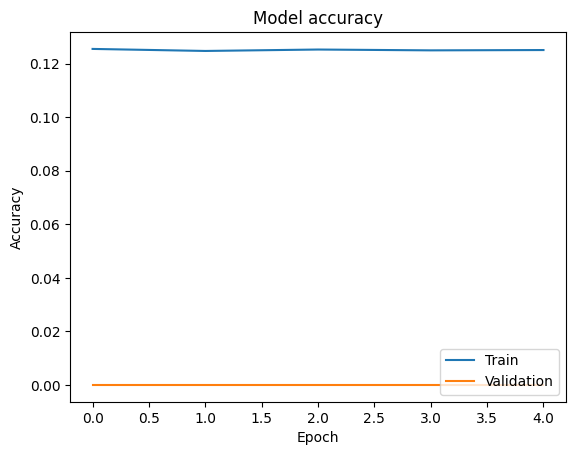

In [245]:

n = y.unique().max() - y.unique().min() +1
def build_model(x,n):
  inputs = tf.keras.Input(shape=(x.shape[1]))
  x = layers.Dense(64, activation='relu')(inputs)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(n, activation='softmax')(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the model
model = build_model(X_resampled,n)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer='rmsprop', loss= loss, metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, batch_size=32, epochs=5, validation_split=0.2)


# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


The model gives lousy accuracy 

Even with an oversampling, it overfits the 0 class

Let's try an undersampling 

In [248]:
data = df.copy()
# Split the data into features and labels
x = data.iloc[:, :-1]
y = data.iloc[:, -1]

from imblearn.under_sampling import NearMiss

undersample = NearMiss(version=1, n_neighbors=3)

X_resampled, y_resampled = undersample.fit_resample(x, y)


array([[<AxesSubplot: title={'center': "('class',)"}>]], dtype=object)

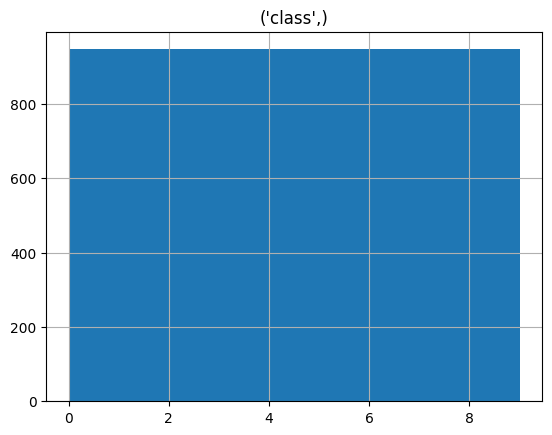

In [249]:
data = pd.DataFrame(X_resampled)
data['class'] = y_resampled
data.hist(column = ['class'])

Epoch 1/5
237/237 [==============================] - 5s 8ms/step - loss: 62.4854 - accuracy: 0.1972 - val_loss: 3.2945 - val_accuracy: 0.0011
Epoch 2/5
237/237 [==============================] - 2s 7ms/step - loss: 2.2019 - accuracy: 0.2236 - val_loss: 4.5758 - val_accuracy: 0.0000e+00
Epoch 3/5
237/237 [==============================] - 1s 6ms/step - loss: 1.8926 - accuracy: 0.2294 - val_loss: 5.7406 - val_accuracy: 0.0000e+00
Epoch 4/5
237/237 [==============================] - 1s 6ms/step - loss: 1.8479 - accuracy: 0.2239 - val_loss: 7.0816 - val_accuracy: 0.0000e+00
Epoch 5/5
237/237 [==============================] - 2s 6ms/step - loss: 1.8182 - accuracy: 0.2350 - val_loss: 8.8848 - val_accuracy: 0.0000e+00


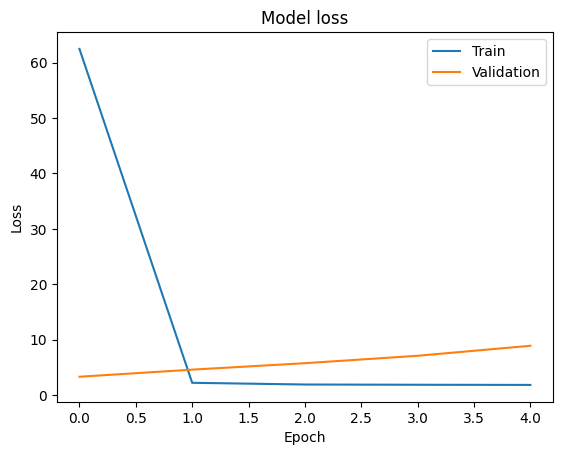

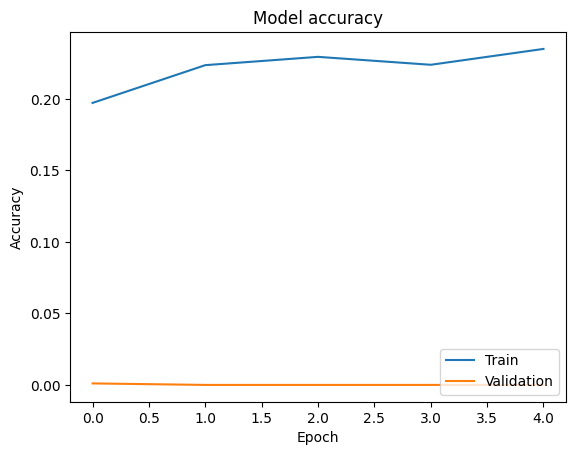

In [250]:

n = y_resampled.unique().max() - y_resampled.unique().min() +1
def build_model(x,n):
  inputs = tf.keras.Input(shape=(x.shape[1]))
  x = layers.Dense(64, activation='relu')(inputs)
  x = layers.Dropout(0.25)(x)
  x = layers.Dense(64, activation='relu')(x)
  x = layers.Dropout(0.5)(x)
  x = layers.Dense(n, activation='softmax')(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

# Build the model
model = build_model(X_resampled,n)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Compile the model
model.compile(optimizer='rmsprop', loss= loss, metrics=['accuracy'])

# Train the model
history = model.fit(X_resampled, y_resampled, batch_size=32, epochs=5, validation_split=0.2)


# Plot the loss and accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

Resampling seems to give out bad results 

In [255]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

data = df.copy()
# Split the data into features and labels
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
y_pred = clf.predict(X)
acc_score = accuracy_score(y, y_pred)

print(f'Accuracy for 100 estimators : {acc_score} ')

Accuracy for 100 estimators : 0.9999855351976856 


In [256]:
mask = y_pred.reshape(height, width)

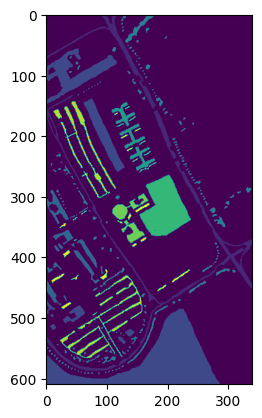

In [258]:
plt.imshow(mask)

The RandomForestClassifier gives us the best prediction model for the segmentation

# Part 2

In [284]:
from my_HSI import open_hsi_mask , open_hsi
hsi_image = open_hsi('indian_pines.mat').open_image()
hsi_image_corrected = open_hsi('indian_pines_corrected.mat').open_image()
hsi_mask = open_hsi_mask('Indian_pines.mat', 'indian_pines_gt.mat').open_ground_truth()

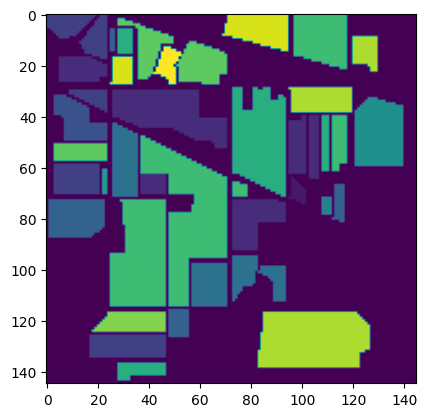

In [286]:
plt.imshow(hsi_mask)

In [289]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import StandardScaler
height, width, layers = hsi_image.shape
# reshape the image to a 1D array of pixels and 103 features
df = pd.DataFrame(hsi_image.reshape(-1,layers)) 
feature_columns = [f'band_{i}' for i in range(layers)]
df.columns = [feature_columns]
# reshape the mask to a 1D array of pixels
df['class'] = hsi_mask.reshape(-1)
# get the features and the labels
y = df['class'].values
X = df.drop('class', axis = 1)

In [297]:
data = df.copy()
# Split the data into features and labels
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, y)
y_pred = clf.predict(X)
acc_score = accuracy_score(y, y_pred)

print(f'Accuracy for 100 estimators : {acc_score} ')

Accuracy for 100 estimators : 0.9999524375743163 


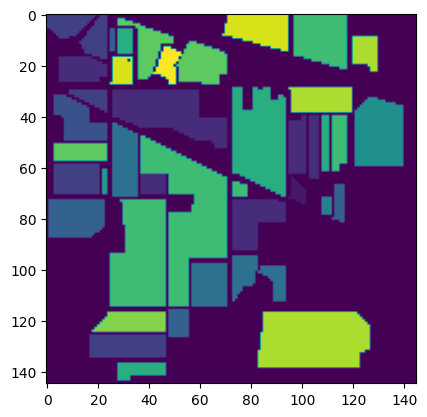

In [298]:
mask = y_pred.reshape(height, width)
plt.imshow(mask)